In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=['fnlwgt', 'education-num'])

In [4]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [5]:
y.head()

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): [>50K, <=50K]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = train_test_split(
    df, y, random_state=42
)

clf = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

In [7]:
print(f"The accuracy of my classifier is "
      f"{clf.score(X_train, y_train):.3f}")

The accuracy of my classifier is 0.759


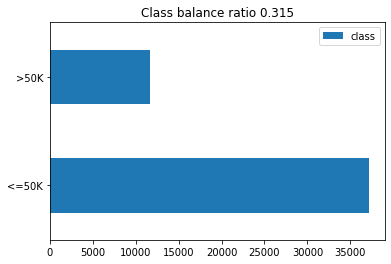

In [8]:
target_counts = y.value_counts()
target_counts.plot(kind='barh', legend=True)
_ = plt.title(f"Class balance ratio "
              f"{target_counts.min() / target_counts.max():.3f}")

### Let's make a baseline

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36631 entries, 27859 to 15795
Data columns (total 12 columns):
age               36631 non-null float64
workclass         34518 non-null category
education         36631 non-null category
marital-status    36631 non-null category
occupation        34509 non-null category
relationship      36631 non-null category
race              36631 non-null category
sex               36631 non-null category
capital-gain      36631 non-null float64
capital-loss      36631 non-null float64
hours-per-week    36631 non-null float64
native-country    36002 non-null category
dtypes: category(8), float64(4)
memory usage: 1.7 MB


In [10]:
num_cols = [col for col in df
            if df[col].dtype.name != 'category']
cat_cols = [col for col in df
            if df[col].dtype.name == 'category']

In [11]:
print(f"The numerical columns are\n {num_cols}")
print(f"The categorical columns are\n {cat_cols}")

The numerical columns are
 ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
The categorical columns are
 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [12]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknwon',
                  add_indicator=True),
    OneHotEncoder(handle_unknown='ignore')
)
num_preprocessor = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean', add_indicator=True)
)

In [13]:
preprocessor = make_column_transformer(
    (cat_preprocessor, cat_cols),
    (num_preprocessor, num_cols)
)

In [14]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(
    preprocessor, LogisticRegression(max_iter=10000)
)

In [15]:
model.fit(X_train, y_train).score(X_test, y_test)

0.8575874211776268

### The metrics 

In [16]:
def print_metric(metric, clf, X, y_true, metric_params=None):
    assert X.shape[0] == y_true.shape[0], "Different samples size!!!"
    y_pred = clf.predict(X)
    if metric_params is None:
        metric_params = {}
    score = metric(y_true, y_pred, **metric_params)
    print(f"The {metric.__name__.replace('_' , ' ')} "
          f"is {score:.3f}")

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
print_metric(accuracy_score, model, X_test, y_test)

The accuracy score is 0.858


In [19]:
from sklearn.metrics import balanced_accuracy_score

In [20]:
print_metric(balanced_accuracy_score, model, X_test, y_test)

The balanced accuracy score is 0.771


In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

for metric in (precision_score, recall_score, f1_score):
    print_metric(metric, model, X_test, y_test,
                 {'pos_label': '>50K'})

The precision score is 0.737
The recall score is 0.608
The f1 score is 0.667


In [22]:
for metric in (precision_score, recall_score, f1_score):
    print_metric(metric, model, X_test, y_test,
                 {'pos_label': '<=50K'})

The precision score is 0.886
The recall score is 0.934
The f1 score is 0.909


In [23]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      9354
        >50K       0.74      0.61      0.67      2857

    accuracy                           0.86     12211
   macro avg       0.81      0.77      0.79     12211
weighted avg       0.85      0.86      0.85     12211



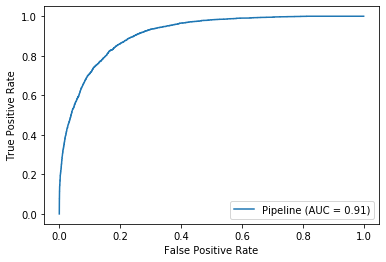

In [24]:
from sklearn.metrics import plot_roc_curve

_ = plot_roc_curve(model, X_test, y_test,
                   pos_label=model.classes_[1])

In [25]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_test)
print(f"The ROC-AUC score is "
      f"{roc_auc_score(y_test, y_pred[:, 1]):.3f}")

The ROC-AUC score is 0.911


### The influence of imbalanced dataset on machine-learning model

#### Linear classifier

In [26]:
def plot_decision_function(X, y, clf, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[np.flatnonzero(y == 1), 0],
               X[np.flatnonzero(y == 1), 1],
               color='yellow', alpha=0.8, edgecolor='k')
    ax.scatter(X[np.flatnonzero(y == 0), 0],
               X[np.flatnonzero(y == 0), 1],
              color='indigo', alpha=0.8, edgecolor='k')

In [27]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.5, 0.5],
                           class_sep=1.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)
model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
_ = model.fit(X_train, y_train)

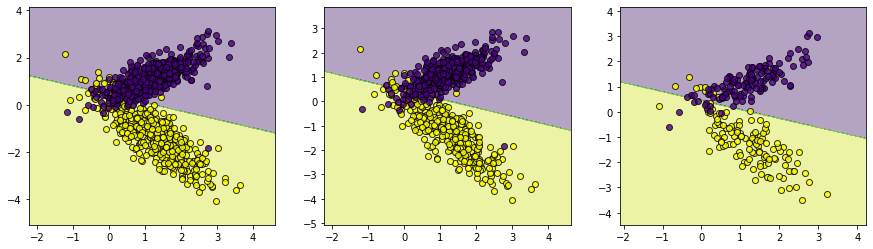

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
plot_decision_function(X, y, model, ax=ax[0])
plot_decision_function(X_train, y_train, model, ax=ax[1])
plot_decision_function(X_test, y_test, model, ax=ax[2])

In [29]:
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.05, 0.95],
                           class_sep=1.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [30]:
_ = model.fit(X_train, y_train)

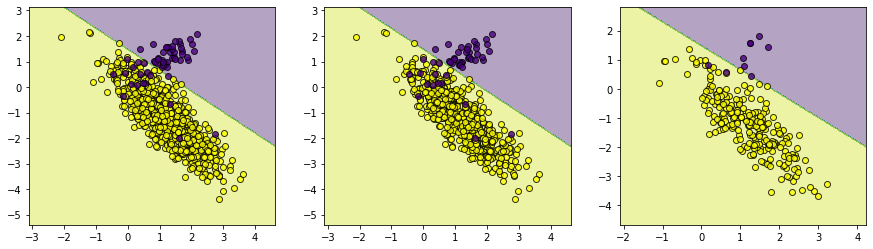

In [31]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
plot_decision_function(X, y, model, ax=ax[0])
plot_decision_function(X_train, y_train, model, ax=ax[1])
plot_decision_function(X_test, y_test, model, ax=ax[2])

Let's recall the loss function for the logistic regression in the binary case:

$L(\theta) = - \frac{1}{m} \sum_{i=1}^{m}\left[ y^{(i)} \log \left( h_{\theta} (x^{(i)}) \right) + \left( 1 - y^{(i)} \right) \log \left( 1 - h_{\theta} (x^{(i)}) \right) \right]$

We sum over the sample without applying any weights.

#### Tree-based model

![](hellinger.png)

![](proba.png)

### What can we do about it?

In [32]:
df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=['fnlwgt', 'education-num'])

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = train_test_split(
    df, y, random_state=42
)
y_train = ((y_train == ">50K").astype(int) * 2) - 1 
y_test = ((y_test == ">50K").astype(int) * 2) - 1 

In [64]:
mask_single_class = y_train == 1

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {'oneclasssvm__nu': uniform(0, 1)}

model = make_pipeline(
    preprocessor, OneClassSVM(kernel='linear', nu=0.1)
)
model_cv = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=15, n_jobs=-1,
    scoring='balanced_accuracy'
)
_ = model_cv.fit(X_train[mask_single_class], y_train[mask_single_class])

In [56]:
y_pred = model.predict(X_test)

In [58]:
balanced_accuracy_score(y_test, y_pred)

0.6538242162268473

In [44]:
from sklearn.neighbors import LocalOutlierFactor

model = make_pipeline(
    preprocessor, LocalOutlierFactor(n_jobs=-1, novelty=True, n_neighbors=35)
)
_ = model.fit(X_train[mask_single_class], y_train[mask_single_class])

In [45]:
y_pred = model.predict(X_test)

In [46]:
y_test_xxx = ((y_test == ">50K").astype(int) * 2) - 1 

In [47]:
balanced_accuracy_score(y_test_xxx, y_pred)

0.49583872447845184

In [89]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import IsolationForest

cat_preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknwon',
                  add_indicator=True),
    OrdinalEncoder()
)
num_preprocessor = SimpleImputer(strategy='mean', add_indicator=True)

model = make_pipeline(
    preprocessor, IsolationForest(n_estimators=500, n_jobs=-1, max_samples=10000)
)

In [90]:
_ = model.fit(X_train, y_train)

In [91]:
y_pred = model.predict(X_test)

In [92]:
y_test_xxx = ((y_test == ">50K").astype(int) * 2) - 1 

In [93]:
balanced_accuracy_score(y_test_xxx, y_pred)

0.49970343556733104